# Iris

## Setup

### Teradata Setup

In [1]:
# Teradata Setup
from teradatasql import connect
from teradataml.context.context import *
from teradataml.dataframe.dataframe import DataFrame
from teradataml.dataframe.copy_to import copy_to_sql
import getpass
import teradataml as td

In [2]:
# connect to database
HOST='sdt53564'
USER='KA255049'
TEMP_DB ='KA255049'
# create_context(host=HOST,  username=USER, password=getpass.getpass(),  temp_database_name =TEMP_DB)
create_context(host=HOST,  username=USER, password='sahithi30052003',  temp_database_name =TEMP_DB)
conn = get_connection()

### Python Setup

In [3]:
import numpy as np
import pandas as pd
import teradataml as td
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from IPython.display import HTML, TextDisplayObject
import toml
import plotly.graph_objects as go
import plotly.express as px
import plotly.graph_objs as go
import ipywidgets as widgets
import plotly.subplots as sp
from itertools import chain, product
from sspipe import p as p_, px as px_
from sklearn.metrics import silhouette_score
import qgrid
from custom_functions_queries import Teradata_KMeans, find_most_important_columns
import custom_functions_queries
from custom_plots import imp_interactive_plot, update_plot

In [4]:
from helpers import (
    aic_fig,
    coef,
    compare_options,
    extract_options,
    get_option,
    namps,
    label_cm,
)

### Helping functions

In [5]:
def convert(X, y):
    df = (
        X.reset_index()
        .merge(y.reset_index(), on="index")
        .rename(columns={"index": "id"})
        .sort_values(by="id")
        .reset_index(drop=True)
    )
    return df

def namps(table, pi):
    q = (
        f"SELECT HASHAMP(HASHBUCKET(HASHROW({pi}))),COUNT (*) "
        f"from {table} group by 1 order by 1;"
    )
    df = td.get_context().execute(q).fetchall() | p_(
        pd.DataFrame, columns=["amp", "count"]
    ).assign(amp=lambda x: x.amp + 1)
    display(HTML(f"<h3>Data distribution: {table}</h3>"))
    display(df.style.hide())
    
def dict_to_multi_dict(conv_options):
    query_values = [
                v if isinstance(v, list) else [v] for v in conv_options.values()
            ]
    return [
                dict(zip(conv_options.keys(), options))
                for options in product(*query_values)
            ]

## Data

In [6]:
td_table = "iris"

iris_td = td.DataFrame(td_table)
iris_local = iris_td.to_pandas().assign(
    target_=lambda x: x.target_.astype("category")
)

In [7]:
namps(td_table, "pi")

amp,count
1,22
2,17
3,19
4,18
5,18
6,15
7,20
8,21


In [8]:
iris_local

,id,sepal_length,sepal_width,petal_length,petal_width,target_
pi,,,,,,
76,76,1.159173,-0.592373,0.592246,0.264142,1
101,101,-0.052506,-0.822570,0.762758,0.922303,2
40,40,-1.021849,1.019004,-1.397064,-1.183812,0
122,122,2.249683,-0.592373,1.672157,1.053935,2
80,80,-0.416010,-1.513160,0.023872,-0.130755,1
...,...,...,...,...,...,...
103,103,0.553333,-0.362176,1.046945,0.790671,2
132,132,0.674501,-0.592373,1.046945,1.317199,2
145,145,1.038005,-0.131979,0.819596,1.448832,2


In [9]:
feature_cols = iris_local.columns[1:-1]
target_col = iris_local.columns[-1]
print(feature_cols)
print(target_col)

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], dtype='object')
target_


In [10]:
X = iris_local[feature_cols]
y = iris_local[target_col]

## Selecting Top 2 Important Features

In [11]:
imp_cols = find_most_important_columns(iris_local, 2)

Most important columns:
['sepal_width', 'sepal_length']
Explained variance ratio:
[9.9907678e-01 4.8808827e-04]


## SKLearn Kmeans

In [12]:
kmeans_options = {
    "n_clusters": [2,3,4,5,6,7,8], 
    "init":'k-means++', 
    "n_init":1, 
    "max_iter":300, 
    "tol":0.0001, 
    "verbose":0, 
    "random_state":None, 
    "copy_x":True, 
    "algorithm":'lloyd'
}

display(HTML("<h4>Kmeans Options:</h4>"))
display(kmeans_options)

{'n_clusters': [2, 3, 4, 5, 6, 7, 8],
 'init': 'k-means++',
 'n_init': 1,
 'max_iter': 300,
 'tol': 0.0001,
 'verbose': 0,
 'random_state': None,
 'copy_x': True,
 'algorithm': 'lloyd'}

### For Important Columns

In [13]:
kmeans_multiple_options = dict_to_multi_dict(kmeans_options)
sk_results = [pd.DataFrame() for i in range(len(kmeans_multiple_options))]
sk_cluster_centers = {}
for i in range(len(kmeans_multiple_options)):
    sklearn_kmeans = KMeans(**kmeans_multiple_options[i]).fit(X[imp_cols])
    sk_results[i] = X[imp_cols].copy()
    sk_results[i]['cluster_id'] = sklearn_kmeans.predict(X[imp_cols])
    sk_cluster_centers[f'Run {i}'] = sklearn_kmeans.cluster_centers_.tolist()

In [14]:
sk_results[0].head(5)

,sepal_width,sepal_length,cluster_id
pi,,,
76,-0.592373,1.159173,0
101,-0.822570,-0.052506,0
40,1.019004,-1.021849,1
122,-0.592373,2.249683,0
80,-1.513160,-0.416010,0


In [15]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(sk_results[0]['petal length (cm)'], sk_results[0]['petal width (cm)'], c=sk_results[0]['cluster_id'])
# plt.show()

In [16]:
display(HTML("<h1>SkLearn KMeans Clusters for All Runs</h1>"))
imp_interactive_plot(sk_results, sk_cluster_centers, imp_cols)

interactive(children=(Dropdown(description='Run', options=(0, 1, 2, 3, 4, 5, 6), value=0), Output()), _dom_cla…

### For All Columns

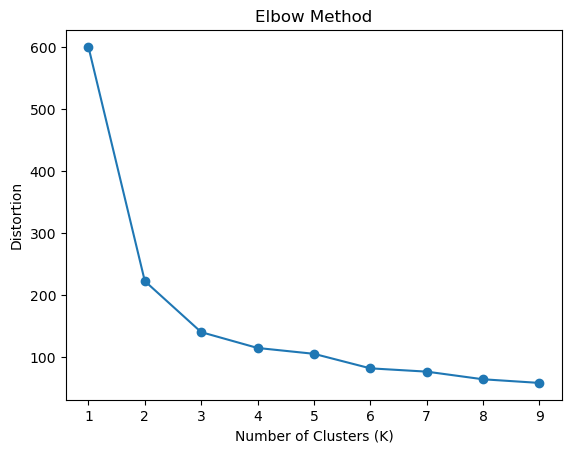

In [17]:
display(HTML(f"<h3>Elbow Method: </h3>"))
k_values = range(1, 10)
distortions = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, init = 'k-means++', n_init=1)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, distortions, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

In [18]:
sk_results_all = [pd.DataFrame() for i in range(len(kmeans_multiple_options))]
sk_cluster_centers_all = {}
silhouette_all = {}
for i in range(len(kmeans_multiple_options)):
    sklearn_kmeans = KMeans(**kmeans_multiple_options[i]).fit(X)
    sk_results_all[i] = X.copy()
    sk_results_all[i]['cluster_id'] = sklearn_kmeans.predict(X)
    sk_cluster_centers_all[f'Run {i}'] = sklearn_kmeans.cluster_centers_.tolist()
    silhouette_all[f'Run {i}'] = silhouette_score(X, sk_results_all[i].cluster_id)

In [19]:
sk_results_all[0].head()

,sepal_length,sepal_width,petal_length,petal_width,cluster_id
pi,,,,,
76,1.159173,-0.592373,0.592246,0.264142,0
101,-0.052506,-0.822570,0.762758,0.922303,0
40,-1.021849,1.019004,-1.397064,-1.183812,1
122,2.249683,-0.592373,1.672157,1.053935,0
80,-0.416010,-1.513160,0.023872,-0.130755,0


In [20]:
display(HTML(f"<h3>Silhouette Scores: </h3>"))
display(silhouette_all)

{'Run 0': 0.5817500491982808,
 'Run 1': 0.45994823920518646,
 'Run 2': 0.38694104154427816,
 'Run 3': 0.35316019854021224,
 'Run 4': 0.34696953015575616,
 'Run 5': 0.34086959305067116,
 'Run 6': 0.3426312720765483}

In [21]:
run_names = list(silhouette_all.keys())
scores = list(silhouette_all.values())
run_details = [f"Run {i}: {kmeans_multiple_options[i]}" for i in range(len(kmeans_multiple_options))]


fig = go.Figure(data=go.Bar(x=run_names, y=scores, hovertext=run_details))
fig.update_layout(title='Silhouette Scores for Multiple Runs',
                  xaxis_title='Run',
                  yaxis_title='Silhouette Score')

# Show the interactive graph
fig.show()

## TD KMeans 

from [TD_KMeans:Syntax](https://teradata-pe.atlassian.net/wiki/spaces/SQLEA/pages/26806435/TD+KMeans#TD_KMeans-Section4.Signature)

    SELECT * FROM TD_KMeans (
    ON { table | view | (query) } as InputTable
    [ ON { table | view | (query) } as InitialCentroidsTable DIMENSION ]
    [ OUT [ PERMANENT | VOLATILE ] TABLE ModelTable(model_output_table_name) ]
    USING
    IdColumn('id_column')
    TargetColumns({'target_column'|'target_column_range'}[,...])
    [ InitialCentroidsMethod({'random'|'kmeans++'}) ]
    [ NumClusters(number_of_clusters) ]
    [ Seed(seed_value) ]
    [ StopThreshold(threshold_value) ]
    [ MaxIterNum(number_of_iterations) ]
    [ NumInit(num_init) ]
    [ OutputClusterAssignment({'true'|'t'|'yes'|'y'|'1'|'false'|'f'|'no'|'n'|'0'}) ]
    ) as alias;

In [22]:
td_options = {'InitialCentroidsMethod': 'kmeans++',
             'NumClusters': [2,3,4,5,6,7],
             'MaxIterNum': 10,
             'Seed': 42,
             'StopThreshold': 0.0395,
             'NumInit': 1,
             'output_table': 'kmeans_iris',
             'fit_input_table': 'iris',
             'predict_input_table':'iris'
             }

display(HTML("<h3>Model Options:</h3>"))
display(td_options)
variable_options = [
    c for c in td_options.keys() if isinstance(td_options[c], list)
]
ncombinations = np.prod([len(td_options[k]) for k in variable_options])
display(HTML(f"<b>This will result in {ncombinations} combinations being tested.</b>"))

{'InitialCentroidsMethod': 'kmeans++',
 'NumClusters': [2, 3, 4, 5, 6, 7],
 'MaxIterNum': 10,
 'Seed': 42,
 'StopThreshold': 0.0395,
 'NumInit': 1,
 'output_table': 'kmeans_iris',
 'fit_input_table': 'iris',
 'predict_input_table': 'iris'}

### For Important Columns

In [23]:
tdkmeans = Teradata_KMeans()
tdkmeans.td_kmeans(conn, pd.Index(imp_cols), td_options)

TD_KMeans Fit, Predict and Sillhouette Calculation Successful for All Iterations in 0.874 secs


In [24]:
display(HTML("<h2>First Iteration</h2>"))
print('Fit Query')
print(100*'-')
print(custom_functions_queries.query.render(**tdkmeans.option_dicts[0], target_col_list = tdkmeans.target_col_list))
print('\n')
print('Predict Query')
print(100*'-')
print(custom_functions_queries.predict_query.render(**tdkmeans.option_dicts[0], target_col_list = tdkmeans.target_col_list))
print('\n')
print(100*'-')
print('Model Table')
tdkmeans.model_tables[0].sort_index()

Fit Query
----------------------------------------------------------------------------------------------------

    CREATE MULTISET VOLATILE TABLE kmeans_iris AS(
    SELECT * FROM TD_KMeans(
        ON iris AS InputTable
        USING
        IdColumn('id')
        TargetColumns('sepal_width', 'sepal_length')
        InitialCentroidsMethod('kmeans++')
        NumClusters(2)
        Seed(42)
        StopThreshold(0.0395)
        MaxIterNum(10)
        NumInit(1)
    ) AS dt
    ) WITH DATA ON COMMIT PRESERVE ROWS;


Predict Query
----------------------------------------------------------------------------------------------------

    CREATE MULTISET VOLATILE TABLE kmeans_results AS (
    SELECT * FROM TD_KMeansPredict ( 
    ON iris as InputTable
    ON kmeans_iris as ModelTable DIMENSION
    USING
    OutputDistance('True')
    Accumulate('sepal_width', 'sepal_length')
    ) as dt
    ) WITH DATA ON COMMIT PRESERVE ROWS;


--------------------------------------------------------------

,td_clusterid_kmeans,sepal_width,sepal_length,td_size_kmeans,td_withinss_kmeans,id,td_modelinfo_kmeans
0,1.0,0.903906,-0.978229,50.0,40.390185,None,None
1,NaN,NaN,NaN,NaN,NaN,None,Number of Iterations : 5
2,NaN,NaN,NaN,NaN,NaN,None,Total_WithinSS : 1.66951709339345E+02
3,NaN,NaN,NaN,NaN,NaN,None,Between_SS : 1.33048290660655E+02
4,NaN,NaN,NaN,NaN,NaN,None,Method for InitialCentroids : KMeans++
5,NaN,NaN,NaN,NaN,NaN,None,Number of Clusters : 2
6,NaN,NaN,NaN,NaN,NaN,None,Converged : True
7,0.0,-0.451953,0.489114,100.0,126.561524,None,None


In [25]:
#preparing the tdresults obtained to work with plots
tdk_cluster_centers_imp = {}
for i in range(len(tdkmeans.option_dicts)):
    tdkmeans.results_tables[i] = tdkmeans.results_tables[i].rename(columns={'td_clusterid_kmeans':'cluster_id'})
    tdk_cluster_centers_imp[f'Run {i}'] = sorted(tdkmeans.model_tables[i][["td_clusterid_kmeans"]+imp_cols].dropna().values.tolist(), key = lambda x: x[0])
    tdk_cluster_centers_imp[f'Run {i}'] = [row[1:] for row in tdk_cluster_centers_imp[f'Run {i}']]

In [26]:
from custom_plots import imp_interactive_plot
display(HTML("<h1>TD_KMeans Clusters for All Runs</h1>"))
imp_interactive_plot(tdkmeans.results_tables, tdk_cluster_centers_imp, imp_cols)

interactive(children=(Dropdown(description='Run', options=(0, 1, 2, 3, 4, 5), value=0), Output()), _dom_classe…

### For All Columns

In [27]:
tdkmeans_all = Teradata_KMeans()
tdkmeans_all.td_kmeans(conn, feature_cols, td_options)

TD_KMeans Fit, Predict and Sillhouette Calculation Successful for All Iterations in 0.648 secs


In [28]:
display(HTML("<h2>First Iteration</h2>"))
print('Fit Query')
print(100*'-')
print(custom_functions_queries.query.render(**tdkmeans_all.option_dicts[0], target_col_list = tdkmeans_all.target_col_list))
print('\n')
print('Predict Query')
print(100*'-')
print(custom_functions_queries.predict_query.render(**tdkmeans_all.option_dicts[0], target_col_list = tdkmeans_all.target_col_list))
print('\n')
print(100*'-')
print('Model Table')
tdkmeans_all.model_tables[0].sort_index()

Fit Query
----------------------------------------------------------------------------------------------------

    CREATE MULTISET VOLATILE TABLE kmeans_iris AS(
    SELECT * FROM TD_KMeans(
        ON iris AS InputTable
        USING
        IdColumn('id')
        TargetColumns('sepal_length', 'sepal_width', 'petal_length', 'petal_width')
        InitialCentroidsMethod('kmeans++')
        NumClusters(2)
        Seed(42)
        StopThreshold(0.0395)
        MaxIterNum(10)
        NumInit(1)
    ) AS dt
    ) WITH DATA ON COMMIT PRESERVE ROWS;


Predict Query
----------------------------------------------------------------------------------------------------

    CREATE MULTISET VOLATILE TABLE kmeans_results AS (
    SELECT * FROM TD_KMeansPredict ( 
    ON iris as InputTable
    ON kmeans_iris as ModelTable DIMENSION
    USING
    OutputDistance('True')
    Accumulate('sepal_length', 'sepal_width', 'petal_length', 'petal_width')
    ) as dt
    ) WITH DATA ON COMMIT PRESERVE ROWS;




,td_clusterid_kmeans,sepal_length,sepal_width,petal_length,petal_width,td_size_kmeans,td_withinss_kmeans,id,td_modelinfo_kmeans
0,1.0,-1.014579,0.853263,-1.304987,-1.254893,50.0,47.668411,None,None
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Number of Iterations : 4
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Total_WithinSS : 2.22361704965023E+02
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Between_SS : 3.77638295034977E+02
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Method for InitialCentroids : KMeans++
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Number of Clusters : 2
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Converged : True
7,0.0,0.507289,-0.426631,0.652494,0.627447,100.0,174.693294,None,None


In [29]:
display(HTML(f"<h3>Silhouette Scores: </h3>"))
display(tdkmeans_all.silhouette_scores)

{'Run 0': 0.5817500491982808,
 'Run 1': 0.4734674296398449,
 'Run 2': 0.4188923398171004,
 'Run 3': 0.41451382932660846,
 'Run 4': 0.36286119699458974,
 'Run 5': 0.3155063513357689}

In [30]:
run_names = list(tdkmeans_all.silhouette_scores.keys())
scores = list(tdkmeans_all.silhouette_scores.values())
run_details = [f"Run {i}: {tdkmeans_all.option_dicts[i]}" for i in range(len(tdkmeans_all.option_dicts))]


fig = go.Figure(data=go.Bar(x=run_names, y=scores, hovertext=run_details))
fig.update_layout(title='Silhouette Scores for Multiple Runs',
                  xaxis_title='Run',
                  yaxis_title='Silhouette Score')

# Show the interactive graph
fig.show()

In [31]:
display(HTML("<h3>Options</h3>"))
display(
    pd.DataFrame(
        {
            "Options:": variable_options,
            "possible values": [td_options[k] for k in variable_options],
        }
    ).style.hide()
)

Options:,possible values
NumClusters,"[2, 3, 4, 5, 6, 7]"


## Comparing SKlearn KMeans and TD_KMeans Results

### For Important Columns

#### Comparision of Clusters based on options

In [32]:
update_plot(sk_results, sk_cluster_centers, 
            tdkmeans.results_tables, tdk_cluster_centers_imp, 
            kmeans_multiple_options, tdkmeans.option_dicts, imp_cols)


interactive(children=(Dropdown(description='SkLearn Run', options=(0, 1, 2, 3, 4, 5, 6), value=0), Dropdown(de…

### For All Columns

#### Options with Silhouettes

In [33]:
# Python KMeans
display(HTML("<h3>Sklearn: KMeans</h3>"))
sk_kmeans_df = pd.DataFrame()
for i in range(len(kmeans_multiple_options)):
    sk_kmeans_df[f'Run {i}'] = pd.DataFrame.from_dict(kmeans_multiple_options[i], orient='index')
sk_kmeans_results = pd.concat([sk_kmeans_df, pd.DataFrame(silhouette_all, index=["Silhouette"]) ], ignore_index = False)
display(qgrid.show_grid(sk_kmeans_results))

# TD_Kmeans
display(HTML(f"<h3>TD_Kmeans</h3>"))
options_df = pd.DataFrame()
for i in range(len(tdkmeans_all.option_dicts)):
    options_df[f'Run {i}'] = pd.DataFrame.from_dict(tdkmeans_all.option_dicts[i], orient='index')
td_kmeans_results = pd.concat([options_df, pd.DataFrame(tdkmeans_all.silhouette_scores, index=["Silhouette"]) ], ignore_index = False)
display(qgrid.show_grid(td_kmeans_results))

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

#### Silhouette Comparision Plot

In [34]:
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=("SkLearn KMeans", "TD_KMeans"))

# Plot for SkLearn KMeans
run_names = list(silhouette_all.keys())
scores = list(silhouette_all.values())

fig.add_trace(go.Bar(x=run_names, y=scores, name="SkLearn KMeans"), row=1, col=1)
fig.update_xaxes(title_text='Run', row=1, col=1)
fig.update_yaxes(title_text='Silhouette Score', row=1, col=1)

# Plot for TD_KMeans
run_names = list(tdkmeans_all.silhouette_scores.keys())
scores = list(tdkmeans_all.silhouette_scores.values())

fig.add_trace(go.Bar(x=run_names, y=scores, name="TD_KMeans"), row=1, col=2)
fig.update_xaxes(title_text='Run', row=1, col=2)
fig.update_yaxes(title_text='Silhouette Score', row=1, col=2)

# Update layout and show the figure
fig.update_layout(title='Silhouette Scores for Multiple Runs', width=950, height=500)
fig.show()

## Errors

#### TD_Kmeans Errors

In [35]:
display(HTML("<h3>Errors</h3>"))
if tdkmeans.errors is None:
    print("-"*100)
    display(HTML("<h4>None</h4>"))
else:
    print(tdkmeans.errors)

----------------------------------------------------------------------------------------------------


## Comparision of all runs

### TD_KMeans Options

In [36]:
display(options_df)

,Run 0,Run 1,Run 2,Run 3,Run 4,Run 5
InitialCentroidsMethod,kmeans++,kmeans++,kmeans++,kmeans++,kmeans++,kmeans++
NumClusters,2,3,4,5,6,7
MaxIterNum,10,10,10,10,10,10
Seed,42,42,42,42,42,42
StopThreshold,0.0395,0.0395,0.0395,0.0395,0.0395,0.0395
NumInit,1,1,1,1,1,1
output_table,kmeans_iris,kmeans_iris,kmeans_iris,kmeans_iris,kmeans_iris,kmeans_iris
fit_input_table,iris,iris,iris,iris,iris,iris
predict_input_table,iris,iris,iris,iris,iris,iris


### TD_KMeans Queries ran

In [37]:
for i, r in enumerate(tdkmeans_all.q):
    display(HTML(f"<h3>Run {i}</h3>"))
    print(r)
    print("-"*100)


    CREATE MULTISET VOLATILE TABLE kmeans_iris AS(
    SELECT * FROM TD_KMeans(
        ON iris AS InputTable
        USING
        IdColumn('id')
        TargetColumns('sepal_length', 'sepal_width', 'petal_length', 'petal_width')
        InitialCentroidsMethod('kmeans++')
        NumClusters(2)
        Seed(42)
        StopThreshold(0.0395)
        MaxIterNum(10)
        NumInit(1)
    ) AS dt
    ) WITH DATA ON COMMIT PRESERVE ROWS;
----------------------------------------------------------------------------------------------------



    CREATE MULTISET VOLATILE TABLE kmeans_iris AS(
    SELECT * FROM TD_KMeans(
        ON iris AS InputTable
        USING
        IdColumn('id')
        TargetColumns('sepal_length', 'sepal_width', 'petal_length', 'petal_width')
        InitialCentroidsMethod('kmeans++')
        NumClusters(3)
        Seed(42)
        StopThreshold(0.0395)
        MaxIterNum(10)
        NumInit(1)
    ) AS dt
    ) WITH DATA ON COMMIT PRESERVE ROWS;
----------------------------------------------------------------------------------------------------



    CREATE MULTISET VOLATILE TABLE kmeans_iris AS(
    SELECT * FROM TD_KMeans(
        ON iris AS InputTable
        USING
        IdColumn('id')
        TargetColumns('sepal_length', 'sepal_width', 'petal_length', 'petal_width')
        InitialCentroidsMethod('kmeans++')
        NumClusters(4)
        Seed(42)
        StopThreshold(0.0395)
        MaxIterNum(10)
        NumInit(1)
    ) AS dt
    ) WITH DATA ON COMMIT PRESERVE ROWS;
----------------------------------------------------------------------------------------------------



    CREATE MULTISET VOLATILE TABLE kmeans_iris AS(
    SELECT * FROM TD_KMeans(
        ON iris AS InputTable
        USING
        IdColumn('id')
        TargetColumns('sepal_length', 'sepal_width', 'petal_length', 'petal_width')
        InitialCentroidsMethod('kmeans++')
        NumClusters(5)
        Seed(42)
        StopThreshold(0.0395)
        MaxIterNum(10)
        NumInit(1)
    ) AS dt
    ) WITH DATA ON COMMIT PRESERVE ROWS;
----------------------------------------------------------------------------------------------------



    CREATE MULTISET VOLATILE TABLE kmeans_iris AS(
    SELECT * FROM TD_KMeans(
        ON iris AS InputTable
        USING
        IdColumn('id')
        TargetColumns('sepal_length', 'sepal_width', 'petal_length', 'petal_width')
        InitialCentroidsMethod('kmeans++')
        NumClusters(6)
        Seed(42)
        StopThreshold(0.0395)
        MaxIterNum(10)
        NumInit(1)
    ) AS dt
    ) WITH DATA ON COMMIT PRESERVE ROWS;
----------------------------------------------------------------------------------------------------



    CREATE MULTISET VOLATILE TABLE kmeans_iris AS(
    SELECT * FROM TD_KMeans(
        ON iris AS InputTable
        USING
        IdColumn('id')
        TargetColumns('sepal_length', 'sepal_width', 'petal_length', 'petal_width')
        InitialCentroidsMethod('kmeans++')
        NumClusters(7)
        Seed(42)
        StopThreshold(0.0395)
        MaxIterNum(10)
        NumInit(1)
    ) AS dt
    ) WITH DATA ON COMMIT PRESERVE ROWS;
----------------------------------------------------------------------------------------------------


### TD_KMeans Model Tables

In [38]:
for i, r in enumerate(tdkmeans_all.model_tables[:50]):
    display(HTML(f"<h3>Run {i}</h3>"))
    display(r)
    print("-"*100)

,td_clusterid_kmeans,sepal_length,sepal_width,petal_length,petal_width,td_size_kmeans,td_withinss_kmeans,id,td_modelinfo_kmeans
0,1.0,-1.014579,0.853263,-1.304987,-1.254893,50.0,47.668411,None,None
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Number of Iterations : 4
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Total_WithinSS : 2.22361704965023E+02
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Between_SS : 3.77638295034977E+02
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Method for InitialCentroids : KMeans++
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Number of Clusters : 2
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Converged : True
7,0.0,0.507289,-0.426631,0.652494,0.627447,100.0,174.693294,None,None


----------------------------------------------------------------------------------------------------


,td_clusterid_kmeans,sepal_length,sepal_width,petal_length,petal_width,td_size_kmeans,td_withinss_kmeans,id,td_modelinfo_kmeans
0,1.0,-1.286215,-0.424957,-1.087042,-1.076113,22.0,27.205606,None,None
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Number of Iterations : 3
2,2.0,-0.816231,1.318958,-1.286834,-1.219712,33.0,17.449957,None,None
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Total_WithinSS : 1.91219898584343E+02
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Between_SS : 4.08780101415657E+02
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Method for InitialCentroids : KMeans++
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Number of Clusters : 3
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Converged : True
8,0.0,0.581393,-0.359753,0.698741,0.672894,95.0,146.564336,None,None


----------------------------------------------------------------------------------------------------


,td_clusterid_kmeans,sepal_length,sepal_width,petal_length,petal_width,td_size_kmeans,td_withinss_kmeans,id,td_modelinfo_kmeans
0,1.0,-1.002067,0.906255,-1.303108,-1.256344,49.0,40.390995,None,None
1,3.0,0.357041,-0.394404,0.586562,0.548467,50.0,29.788983,None,None
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Number of Iterations : 6
3,2.0,-0.421517,-1.429452,0.039373,-0.052972,22.0,17.160812,None,None
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Total_WithinSS : 1.14412561818961E+02
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Between_SS : 4.85587438181039E+02
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Method for InitialCentroids : KMeans++
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Number of Clusters : 4
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Converged : True
9,0.0,1.397330,0.233160,1.160620,1.217340,29.0,27.071771,None,None


----------------------------------------------------------------------------------------------------


,td_clusterid_kmeans,sepal_length,sepal_width,petal_length,petal_width,td_size_kmeans,td_withinss_kmeans,id,td_modelinfo_kmeans
0,1.0,-1.002067,0.906255,-1.303108,-1.256344,49.0,40.390995,None,None
1,4.0,2.128516,1.556130,1.501645,1.361077,3.0,0.800656,None,None
2,3.0,0.282819,-0.394297,0.524834,0.484549,43.0,23.692572,None,None
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Number of Iterations : 6
4,2.0,-0.421517,-1.429452,0.039373,-0.052972,22.0,17.160812,None,None
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Total_WithinSS : 1.05322770595884E+02
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Between_SS : 4.94677229404116E+02
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Method for InitialCentroids : KMeans++
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Number of Clusters : 5
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Converged : True


----------------------------------------------------------------------------------------------------


,td_clusterid_kmeans,sepal_length,sepal_width,petal_length,petal_width,td_size_kmeans,td_withinss_kmeans,id,td_modelinfo_kmeans
0,5.0,-0.574460,1.957499,-1.270273,-1.204063,13.0,4.369140,None,None
1,4.0,2.128516,1.556130,1.501645,1.361077,3.0,0.800656,None,None
2,3.0,0.282819,-0.394297,0.524834,0.484549,43.0,23.692572,None,None
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Number of Iterations : 6
4,1.0,-1.156480,0.526639,-1.314965,-1.275223,36.0,13.164656,None,None
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Total_WithinSS : 8.24655711304257E+01
6,2.0,-0.421517,-1.429452,0.039373,-0.052972,22.0,17.160812,None,None
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Between_SS : 5.17534428869574E+02
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Method for InitialCentroids : KMeans++
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Number of Clusters : 6


----------------------------------------------------------------------------------------------------


,td_clusterid_kmeans,sepal_length,sepal_width,petal_length,petal_width,td_size_kmeans,td_withinss_kmeans,id,td_modelinfo_kmeans
0,5.0,-0.574460,1.957499,-1.270273,-1.204063,13.0,4.369140,None,None
1,4.0,2.128516,1.556130,1.501645,1.361077,3.0,0.800656,None,None
2,6.0,0.164321,-0.731703,0.487545,0.413094,38.0,22.433899,None,None
3,3.0,0.698735,0.061386,0.710468,0.748548,25.0,12.699900,None,None
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Number of Iterations : 6
5,1.0,-1.156480,0.526639,-1.314965,-1.275223,36.0,13.164656,None,None
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Total_WithinSS : 7.51315835195645E+01
7,2.0,-0.666423,-1.482467,-0.086014,-0.130755,15.0,10.179628,None,None
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Between_SS : 5.24868416480435E+02
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Method for InitialCentroids : KMeans++


----------------------------------------------------------------------------------------------------


### TD_KMeans Output tables for all the queries ran

In [39]:
for i, r in enumerate(tdkmeans_all.results_tables[:50]):
    display(HTML(f"<h3>Run {i}</h3>"))
    display(r)
    print("-"*100)

,id,td_clusterid_kmeans,td_distance_kmeans,sepal_length,sepal_width,petal_length,petal_width
0,76,0,0.766839,1.159173,-0.592373,0.592246,0.264142
1,101,0,0.754478,-0.052506,-0.822570,0.762758,0.922303
2,40,1,0.202617,-1.021849,1.019004,-1.397064,-1.183812
3,122,0,2.070027,2.249683,-0.592373,1.672157,1.053935
4,80,0,1.732934,-0.416010,-1.513160,0.023872,-0.130755
...,...,...,...,...,...,...,...
145,103,0,0.434176,0.553333,-0.362176,1.046945,0.790671
146,132,0,0.828722,0.674501,-0.592373,1.046945,1.317199
147,145,0,1.034927,1.038005,-0.131979,0.819596,1.448832
148,23,1,0.479456,-0.900681,0.558611,-1.169714,-0.920548


----------------------------------------------------------------------------------------------------


,id,td_clusterid_kmeans,td_distance_kmeans,sepal_length,sepal_width,petal_length,petal_width
0,76,0,0.752570,1.159173,-0.592373,0.592246,0.264142
1,101,0,0.826033,-0.052506,-0.822570,0.762758,0.922303
2,40,2,0.381694,-1.021849,1.019004,-1.397064,-1.183812
3,122,0,1.982431,2.249683,-0.592373,1.672157,1.053935
4,80,0,1.851070,-0.416010,-1.513160,0.023872,-0.130755
...,...,...,...,...,...,...,...
145,103,0,0.368660,0.553333,-0.362176,1.046945,0.790671
146,132,0,0.774052,0.674501,-0.592373,1.046945,1.317199
147,145,0,0.936514,1.038005,-0.131979,0.819596,1.448832
148,23,2,0.829744,-0.900681,0.558611,-1.169714,-0.920548


----------------------------------------------------------------------------------------------------


,id,td_clusterid_kmeans,td_distance_kmeans,sepal_length,sepal_width,petal_length,petal_width
0,76,3,0.873773,1.159173,-0.592373,0.592246,0.264142
1,101,3,0.722394,-0.052506,-0.822570,0.762758,0.922303
2,40,1,0.164901,-1.021849,1.019004,-1.397064,-1.183812
3,122,0,1.302453,2.249683,-0.592373,1.672157,1.053935
4,80,2,0.115446,-0.416010,-1.513160,0.023872,-0.130755
...,...,...,...,...,...,...,...
145,103,3,0.556942,0.553333,-0.362176,1.046945,0.790671
146,132,3,0.971017,0.674501,-0.592373,1.046945,1.317199
147,145,0,0.657516,1.038005,-0.131979,0.819596,1.448832
148,23,1,0.511555,-0.900681,0.558611,-1.169714,-0.920548


----------------------------------------------------------------------------------------------------


,id,td_clusterid_kmeans,td_distance_kmeans,sepal_length,sepal_width,petal_length,petal_width
0,76,3,0.927553,1.159173,-0.592373,0.592246,0.264142
1,101,3,0.737629,-0.052506,-0.822570,0.762758,0.922303
2,40,1,0.164901,-1.021849,1.019004,-1.397064,-1.183812
3,122,0,1.328120,2.249683,-0.592373,1.672157,1.053935
4,80,2,0.115446,-0.416010,-1.513160,0.023872,-0.130755
...,...,...,...,...,...,...,...
145,103,3,0.663717,0.553333,-0.362176,1.046945,0.790671
146,132,0,0.801106,0.674501,-0.592373,1.046945,1.317199
147,145,0,0.452856,1.038005,-0.131979,0.819596,1.448832
148,23,1,0.511555,-0.900681,0.558611,-1.169714,-0.920548


----------------------------------------------------------------------------------------------------


,id,td_clusterid_kmeans,td_distance_kmeans,sepal_length,sepal_width,petal_length,petal_width
0,76,3,0.927553,1.159173,-0.592373,0.592246,0.264142
1,101,3,0.737629,-0.052506,-0.822570,0.762758,0.922303
2,40,1,0.525019,-1.021849,1.019004,-1.397064,-1.183812
3,122,0,1.328120,2.249683,-0.592373,1.672157,1.053935
4,80,2,0.115446,-0.416010,-1.513160,0.023872,-0.130755
...,...,...,...,...,...,...,...
145,103,3,0.663717,0.553333,-0.362176,1.046945,0.790671
146,132,0,0.801106,0.674501,-0.592373,1.046945,1.317199
147,145,0,0.452856,1.038005,-0.131979,0.819596,1.448832
148,23,1,0.461896,-0.900681,0.558611,-1.169714,-0.920548


----------------------------------------------------------------------------------------------------


,id,td_clusterid_kmeans,td_distance_kmeans,sepal_length,sepal_width,petal_length,petal_width
0,76,3,0.942353,1.159173,-0.592373,0.592246,0.264142
1,101,6,0.624745,-0.052506,-0.822570,0.762758,0.922303
2,40,1,0.525019,-1.021849,1.019004,-1.397064,-1.183812
3,122,0,1.096971,2.249683,-0.592373,1.672157,1.053935
4,80,2,0.275180,-0.416010,-1.513160,0.023872,-0.130755
...,...,...,...,...,...,...,...
145,103,3,0.561728,0.553333,-0.362176,1.046945,0.790671
146,132,3,0.929822,0.674501,-0.592373,1.046945,1.317199
147,145,0,0.614598,1.038005,-0.131979,0.819596,1.448832
148,23,1,0.461896,-0.900681,0.558611,-1.169714,-0.920548


----------------------------------------------------------------------------------------------------
